In [1]:
import arviz as az
import bambi as bmb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import seaborn as sns


plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [2]:
seed: int = sum(map(ord, "logistic"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

In [3]:
raw_df = pd.read_csv("../data/brms_epilepsy.csv")

df = raw_df.copy()
df.columns = df.columns.str.lower()

df.head()

,age,base,trt,patient,visit,count,obs,zage,zbase
0,31,11,0,1,1,5,1,0.424995,-0.757173
1,30,11,0,2,1,3,2,0.265284,-0.757173
2,25,6,0,3,1,2,3,-0.533274,-0.944403
3,36,8,0,4,1,4,4,1.223553,-0.869511
4,22,66,0,5,1,7,5,-1.012408,1.302363


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 236 entries, 0 to 235
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   age      236 non-null    int64  
 1   base     236 non-null    int64  
 2   trt      236 non-null    int64  
 3   patient  236 non-null    int64  
 4   visit    236 non-null    int64  
 5   count    236 non-null    int64  
 6   obs      236 non-null    int64  
 7   zage     236 non-null    float64
 8   zbase    236 non-null    float64
dtypes: float64(2), int64(7)
memory usage: 16.7 KB


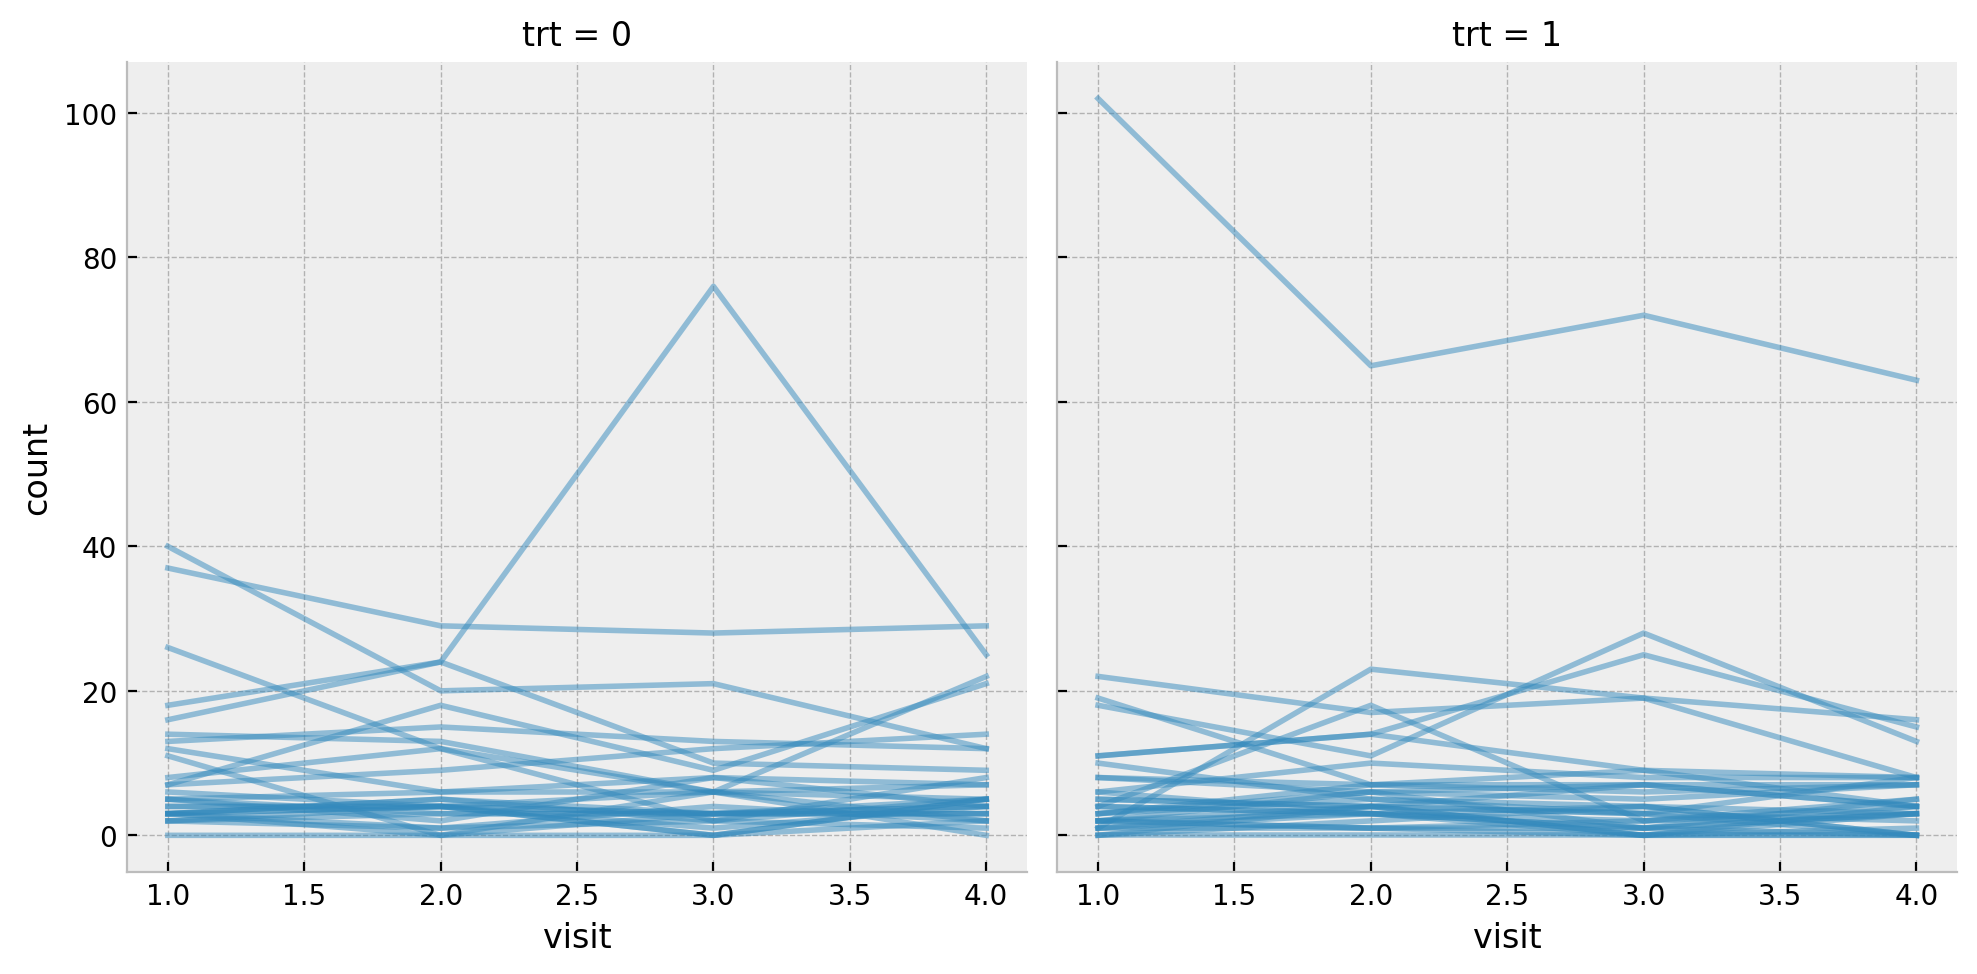

In [5]:
g = sns.relplot(
    data=df,
    x="visit",
    y="count",
    col="trt",
    kind="line",
    units="patient",
    estimator=None,
    alpha=0.5,
)

In [6]:
df.groupby(["trt", "visit"]).agg({"count": [np.mean, np.var, np.min, np.max]})


count                      
               mean         var amin amax
trt visit                                
0   1      9.357143  102.756614    0   40
    2      8.285714   66.656085    0   29
    3      8.714286  213.322751    0   76
    4      7.964286   58.183862    0   29
1   1      8.580645  332.718280    0  102
    2      8.419355  140.651613    0   65
    3      8.129032  193.049462    0   72
    4      6.709677  126.879570    0   63

In [7]:
data = (
    df.query("visit == 4")
    .assign(
        lc_base=lambda x: np.log(x["base"]) - np.mean(np.log(x["base"])),
        lc_age=lambda x: np.log(x["age"]) - np.mean(np.log(x["age"])),
    )
    .reset_index(drop=True)
)

data.head()

,age,base,trt,patient,visit,count,obs,zage,zbase,lc_base,lc_age
0,31,11,0,1,4,3,178,0.424995,-0.757173,-0.756354,0.114204
1,30,11,0,2,4,3,179,0.265284,-0.757173,-0.756354,0.081414
2,25,6,0,3,4,5,180,-0.533274,-0.944403,-1.362490,-0.100908
3,36,8,0,4,4,4,181,1.223553,-0.869511,-1.074808,0.263735
4,22,66,0,5,4,21,182,-1.012408,1.302363,1.035406,-0.228741


In [8]:
data.groupby("trt").agg({"patient": "nunique"})

,patient
trt,
0,28
1,31


In [30]:
diff_means = (
    data.query("trt == 1")["count"].mean() - data.query("trt == 0")["count"].mean()
)

print(f"Sample ATE: {diff_means:.3f}")

Sample ATE: -1.255


In [32]:
negative_binomial_priors = {
    "Intercept": bmb.Prior("Normal", mu=np.log(14), sigma=1),
    "trt": bmb.Prior("Normal", mu=0, sigma=0.5),
    "alpha": bmb.Prior("Gamma", alpha=0.01, beta=0.01),
}

negative_binomial_model = bmb.Model(
    formula="count ~ trt",
    data=data,
    family="negativebinomial",
    link="log",
    priors=negative_binomial_priors,
)

negative_binomial_model


       Formula: count ~ trt
        Family: negativebinomial
          Link: mu = log
  Observations: 59
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 2.6391, sigma: 1.0)
            trt ~ Normal(mu: 0.0, sigma: 0.5)
        
        Auxiliary parameters
            count_alpha ~ Gamma(alpha: 0.01, beta: 0.01)

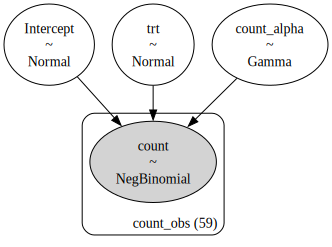

In [33]:
negative_binomial_model.build()
negative_binomial_model.graph()

In [34]:
negative_binomial_idata = negative_binomial_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)

negative_binomial_model.predict(idata=negative_binomial_idata, kind="pps")

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:02.669382
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:05.898421
Transforming variables...
Transformation time =  0:00:00.010987


In [35]:
az.summary(data=negative_binomial_idata, var_names=["Intercept", "trt", "count_alpha"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,2.078,0.186,1.737,2.426,0.001,0.001,19223.0,15043.0,1.0
trt,-0.131,0.243,-0.597,0.316,0.002,0.002,18956.0,14645.0,1.0
count_alpha,1.039,0.224,0.635,1.455,0.002,0.001,19371.0,14773.0,1.0


Text(0.5, 0.98, 'Negative Binomial Regression Model - Trace')

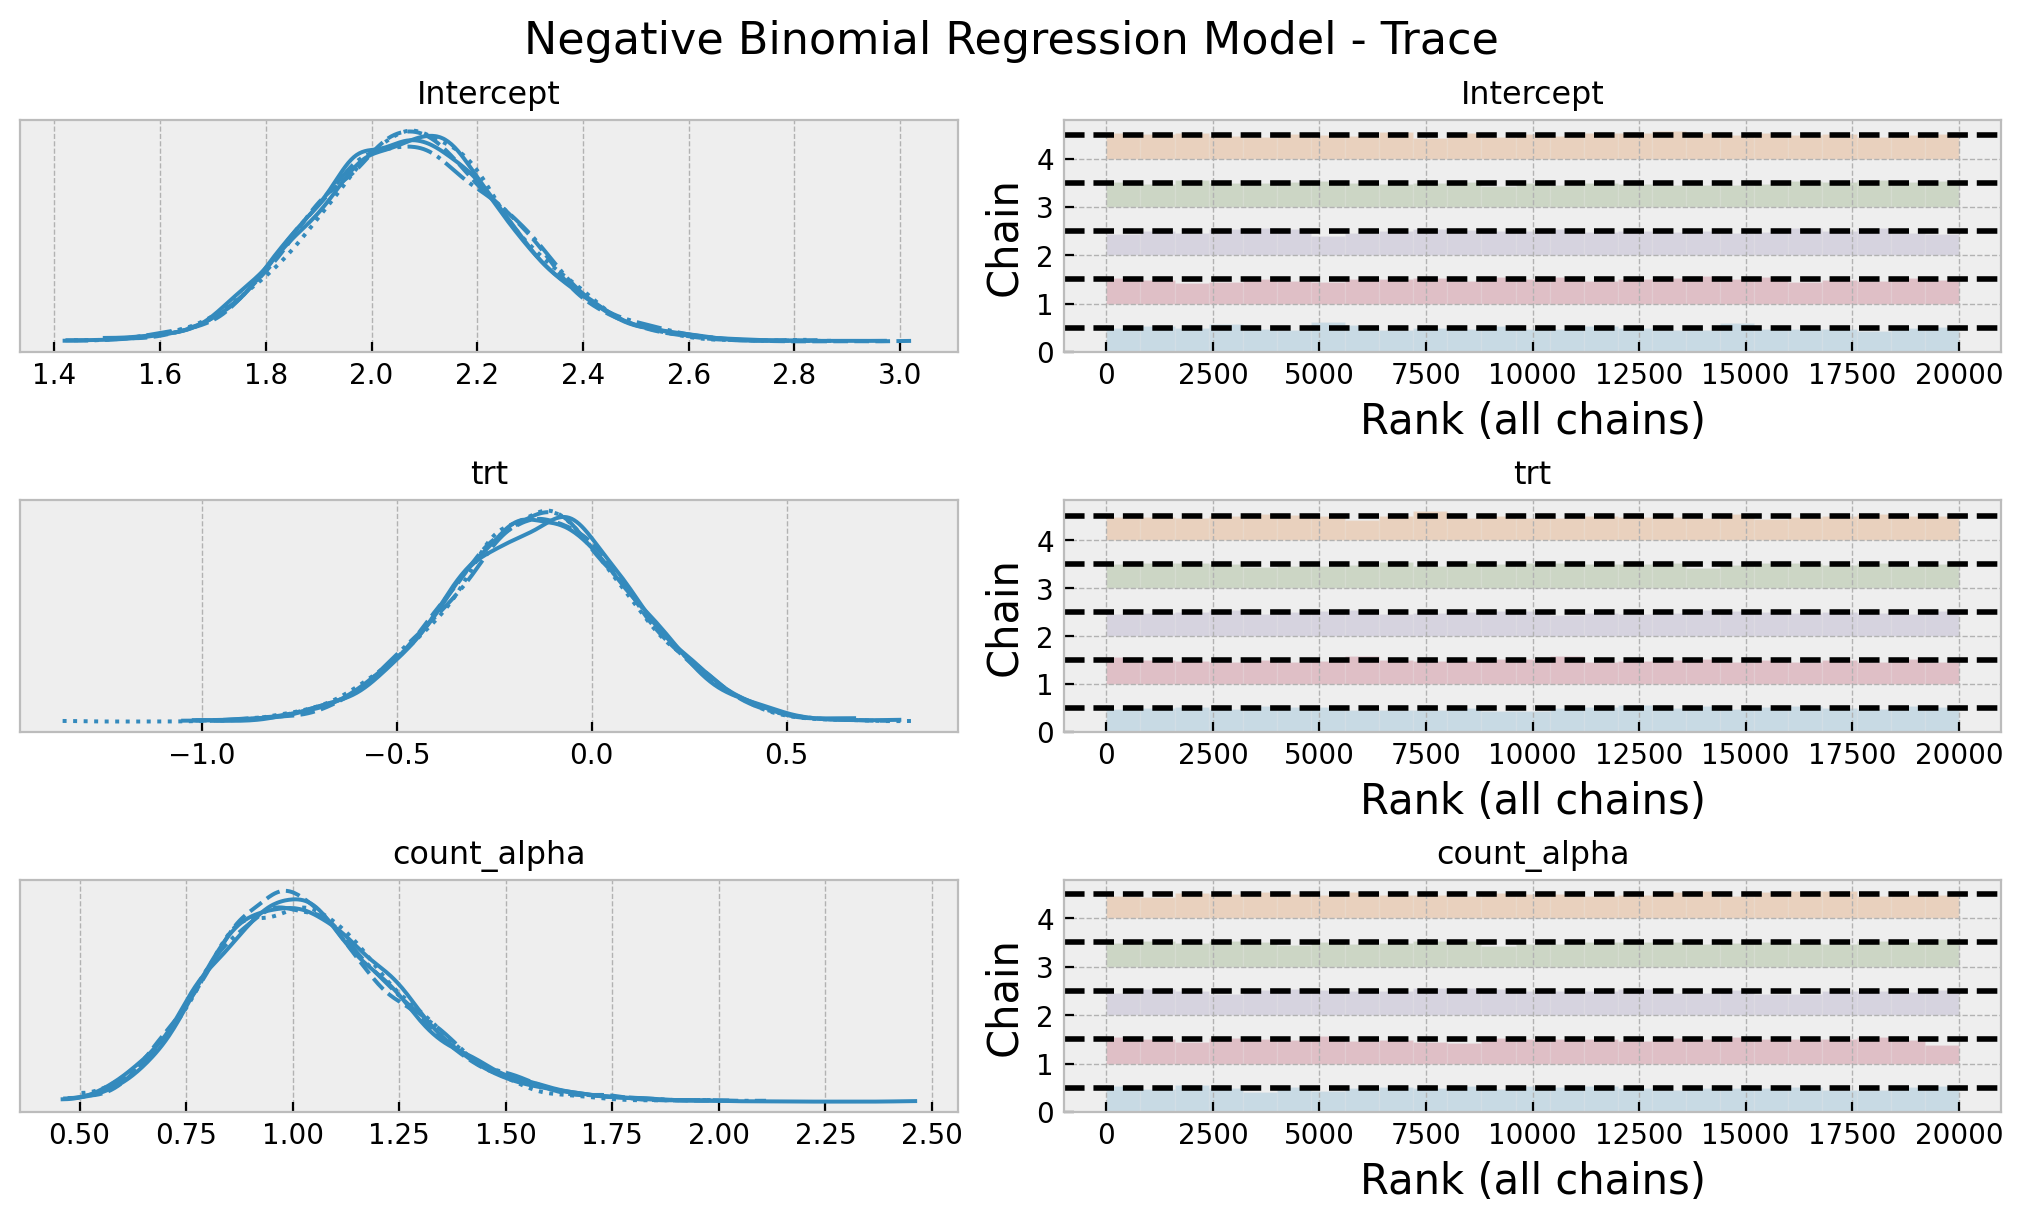

In [36]:
axes = az.plot_trace(
    data=negative_binomial_idata,
    var_names=["Intercept", "trt", "count_alpha"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Negative Binomial Regression Model - Trace", fontsize=16)

[Text(0.5, 1.0, 'Logistic Regression Model - ATE'), Text(0.5, 0, 'ATE')]

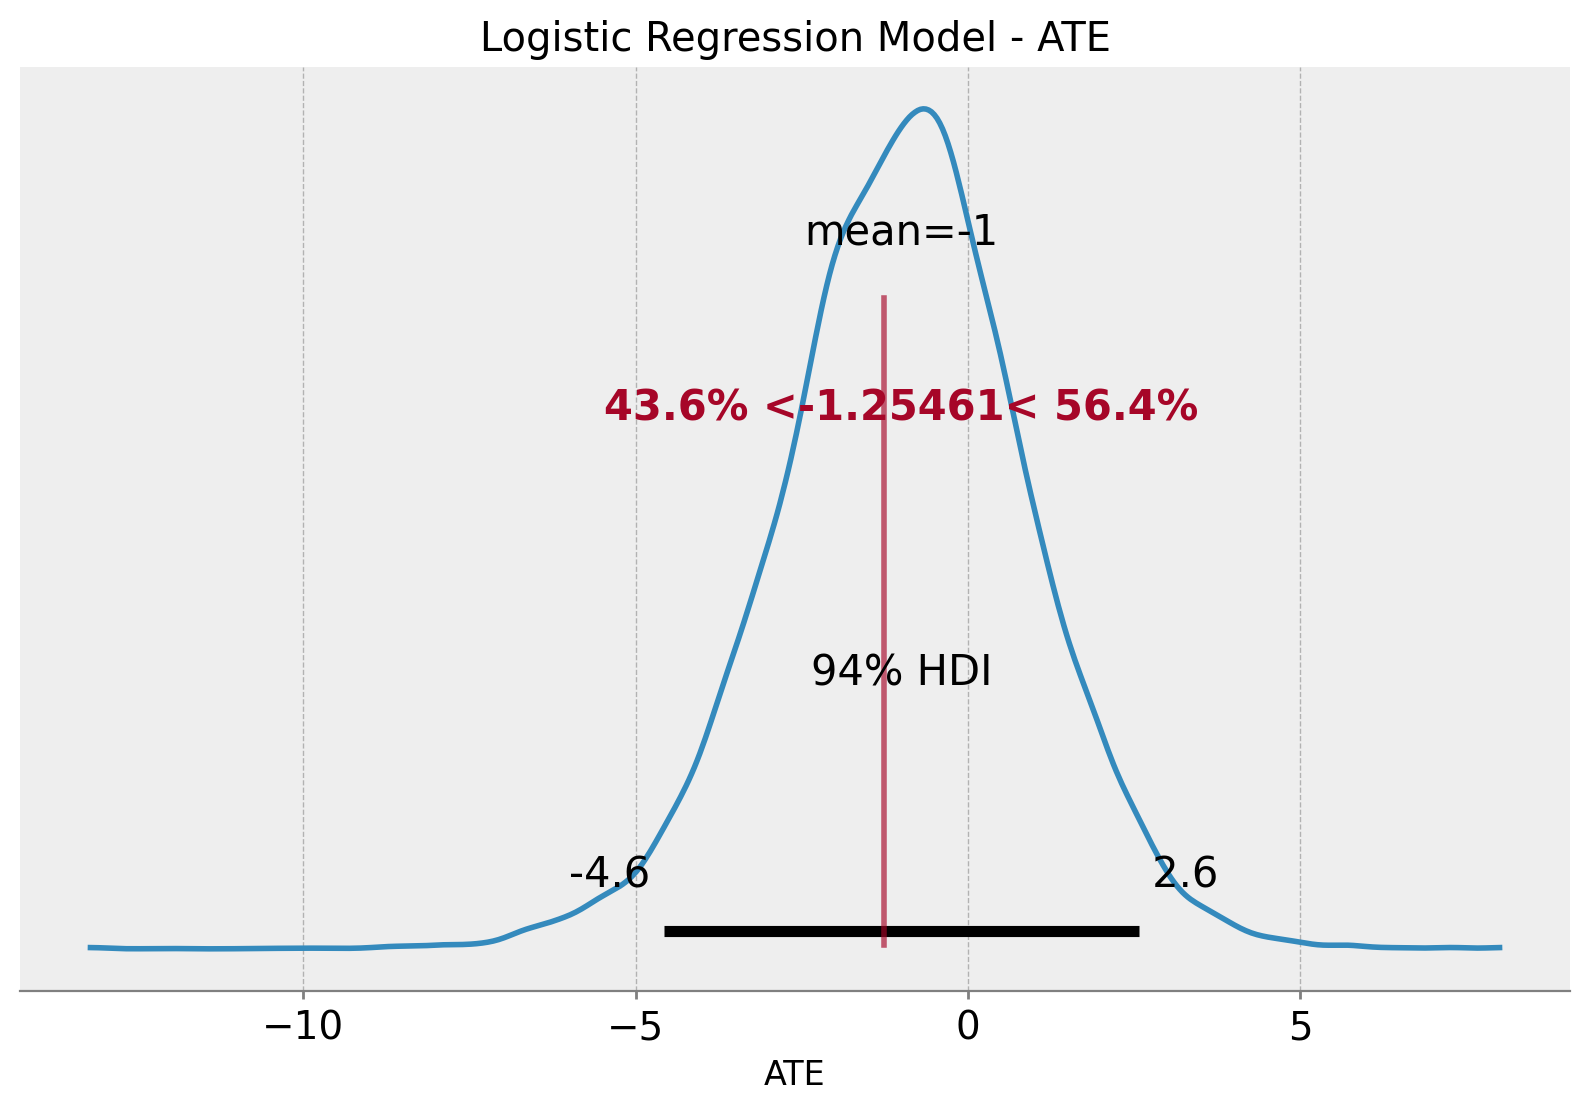

In [37]:
ate_samples = np.exp(
    negative_binomial_idata["posterior"]["Intercept"]
    + negative_binomial_idata["posterior"]["trt"]
) - np.exp(negative_binomial_idata["posterior"]["Intercept"])

fig, ax = plt.subplots()
az.plot_posterior(data=ate_samples, ref_val=diff_means, ax=ax)
ax.set(title="Logistic Regression Model - ATE", xlabel="ATE")


In [48]:
import statsmodels.formula.api as smf


smf.ols("count ~ trt", data=data).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.013
Method:                 Least Squares   F-statistic:                    0.2455
Date:                Wed, 07 Jun 2023   Prob (F-statistic):              0.622
Time:                        12:21:40   Log-Likelihood:                -216.83
No. Observations:                  59   AIC:                             437.7
Df Residuals:                      57   BIC:                             441.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.9643      1.836      4.339      0.000       4.289      11.640
trt           -1.2546      2.532     -0.495      0.622      -6.325       3.816
==============================================================================
Omnibus:                       79.490   Durbin-Watson:                   2.311
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              963.607
Skew:                           3.796   Prob(JB):                    5.69e-210
Kurtosis:                      21.285   Cond. No.                         2.68
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [79]:
gaussian_model_priors = {
    "Intercept": bmb.Prior("Normal", mu=0, sigma=5),
    "trt": bmb.Prior("Normal", mu=0, sigma=5),
    "sigma": bmb.Prior("Exponential", lam=1/10),
}
gaussian_model = bmb.Model(
    formula="count ~ trt",
    data=data,
    family="gaussian",
    link="identity",
    priors=gaussian_model_priors,
)

gaussian_model

       Formula: count ~ trt
        Family: gaussian
          Link: mu = identity
  Observations: 59
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 0.0, sigma: 5.0)
            trt ~ Normal(mu: 0.0, sigma: 5.0)
        
        Auxiliary parameters
            count_sigma ~ Exponential(lam: 0.1)

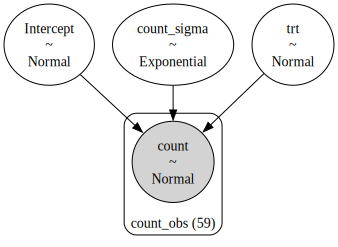

In [80]:
gaussian_model.build()
gaussian_model.graph()

In [81]:
gaussian_idata = gaussian_model.fit(
    draws=4_000, chains=5, nuts_sampler="numpyro", random_seed=rng
)

gaussian_model.predict(idata=gaussian_idata, kind="pps")

/Users/juanitorduz/.local/share/virtualenvs/website_projects-1IZj_WTw/lib/python3.10/site-packages/pymc/sampling/mcmc.py:254: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.739874
Sampling...


  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

Sampling time =  0:00:04.479242
Transforming variables...
Transformation time =  0:00:00.010649


In [82]:
az.summary(data=gaussian_idata, var_names=["Intercept", "trt", "count_sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,7.379,1.730,4.095,10.575,0.012,0.008,21778.0,14831.0,1.0
trt,-0.990,2.282,-5.318,3.249,0.016,0.014,20944.0,14896.0,1.0
count_sigma,9.828,0.929,8.199,11.611,0.007,0.005,17938.0,14687.0,1.0


Text(0.5, 0.98, 'Linear Regression Model - Trace')

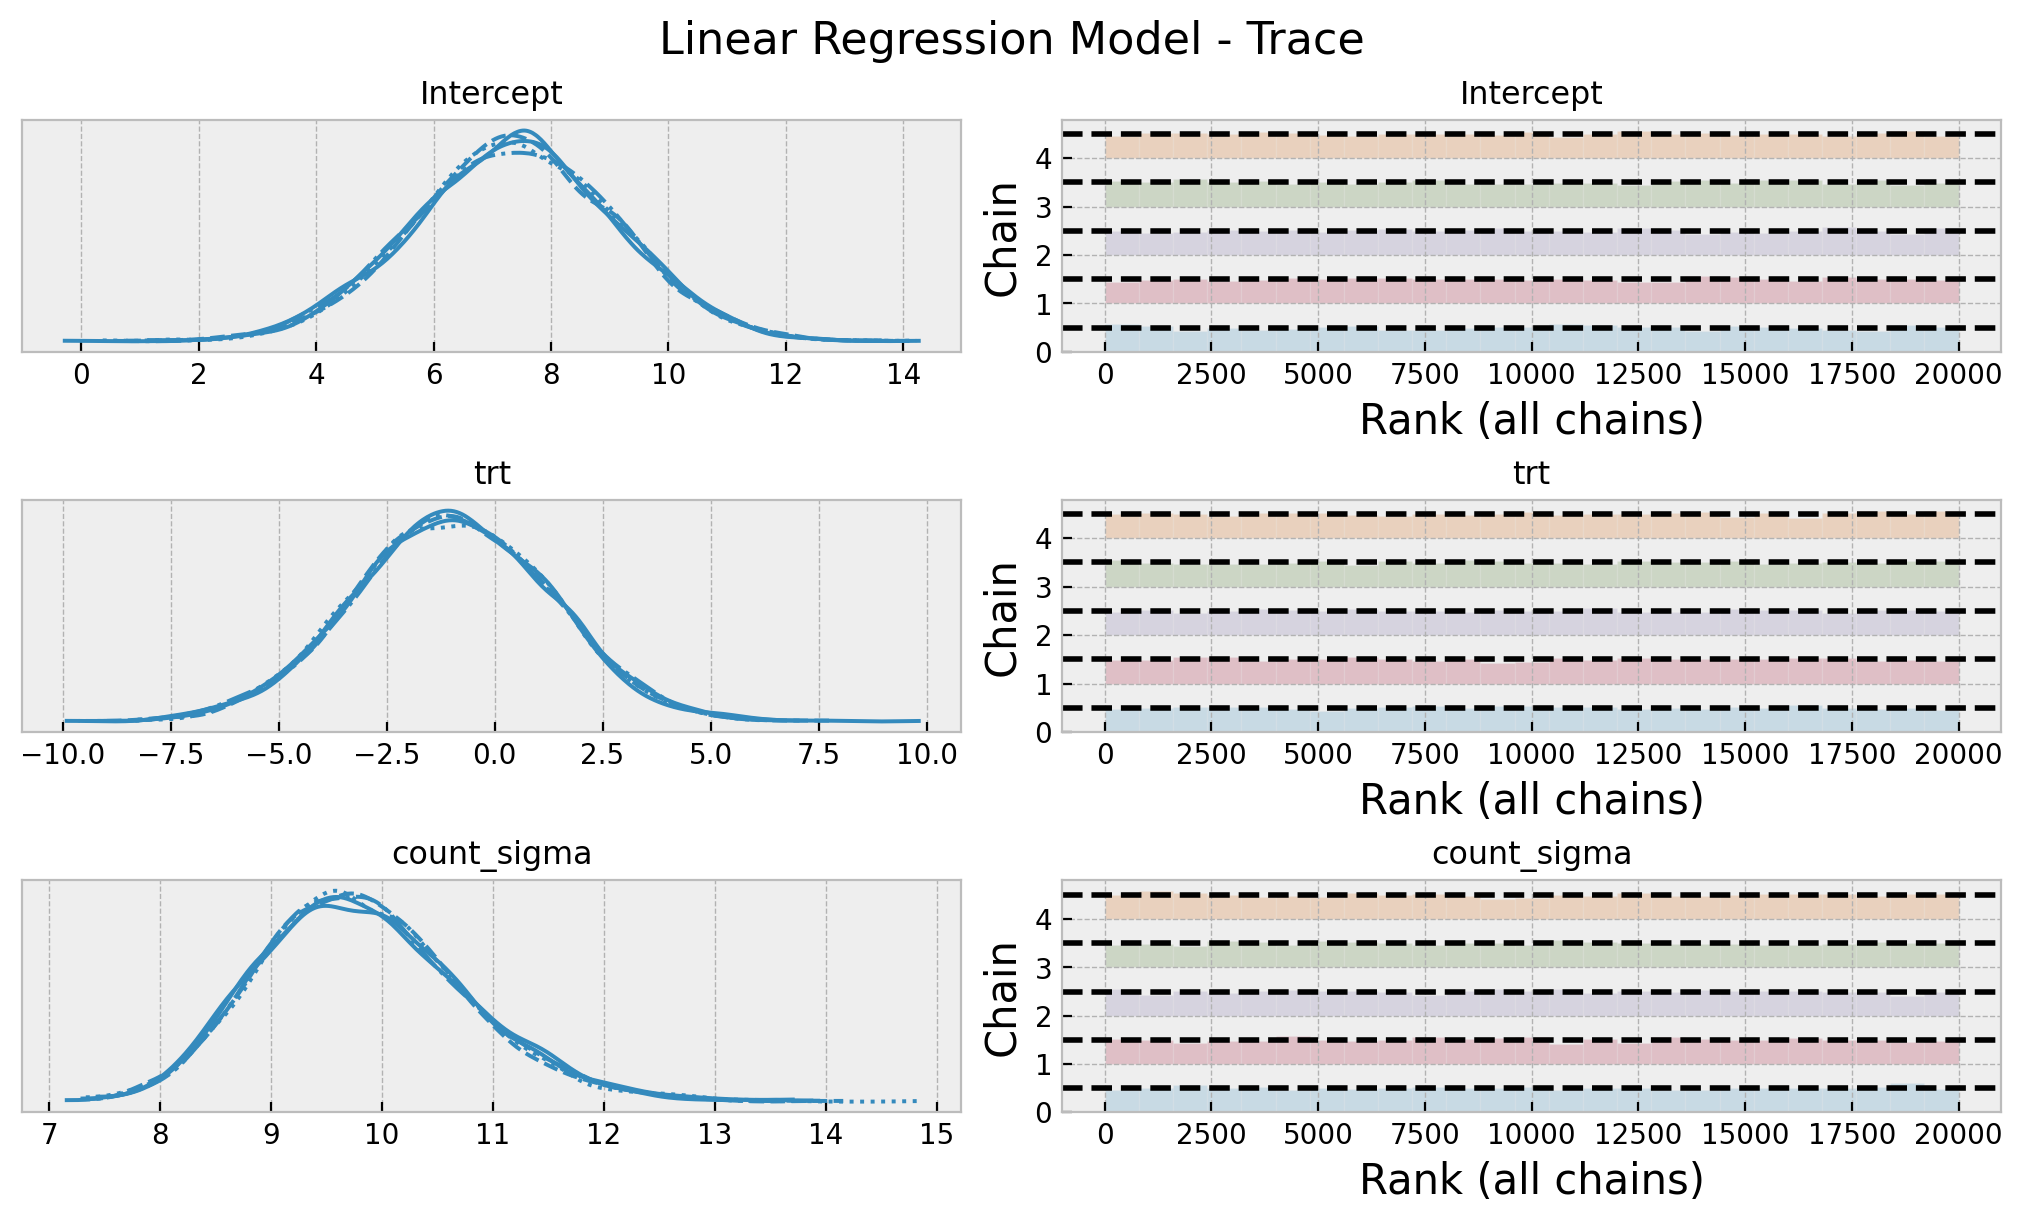

In [83]:
axes = az.plot_trace(
    data=gaussian_idata,
    var_names=["Intercept", "trt", "count_sigma"],
    compact=True,
    kind="rank_bars",
    backend_kwargs={"figsize": (10, 6), "layout": "constrained"},
)
plt.gcf().suptitle("Linear Regression Model - Trace", fontsize=16)

Text(0.5, 1.05, 'ATE Comparison')

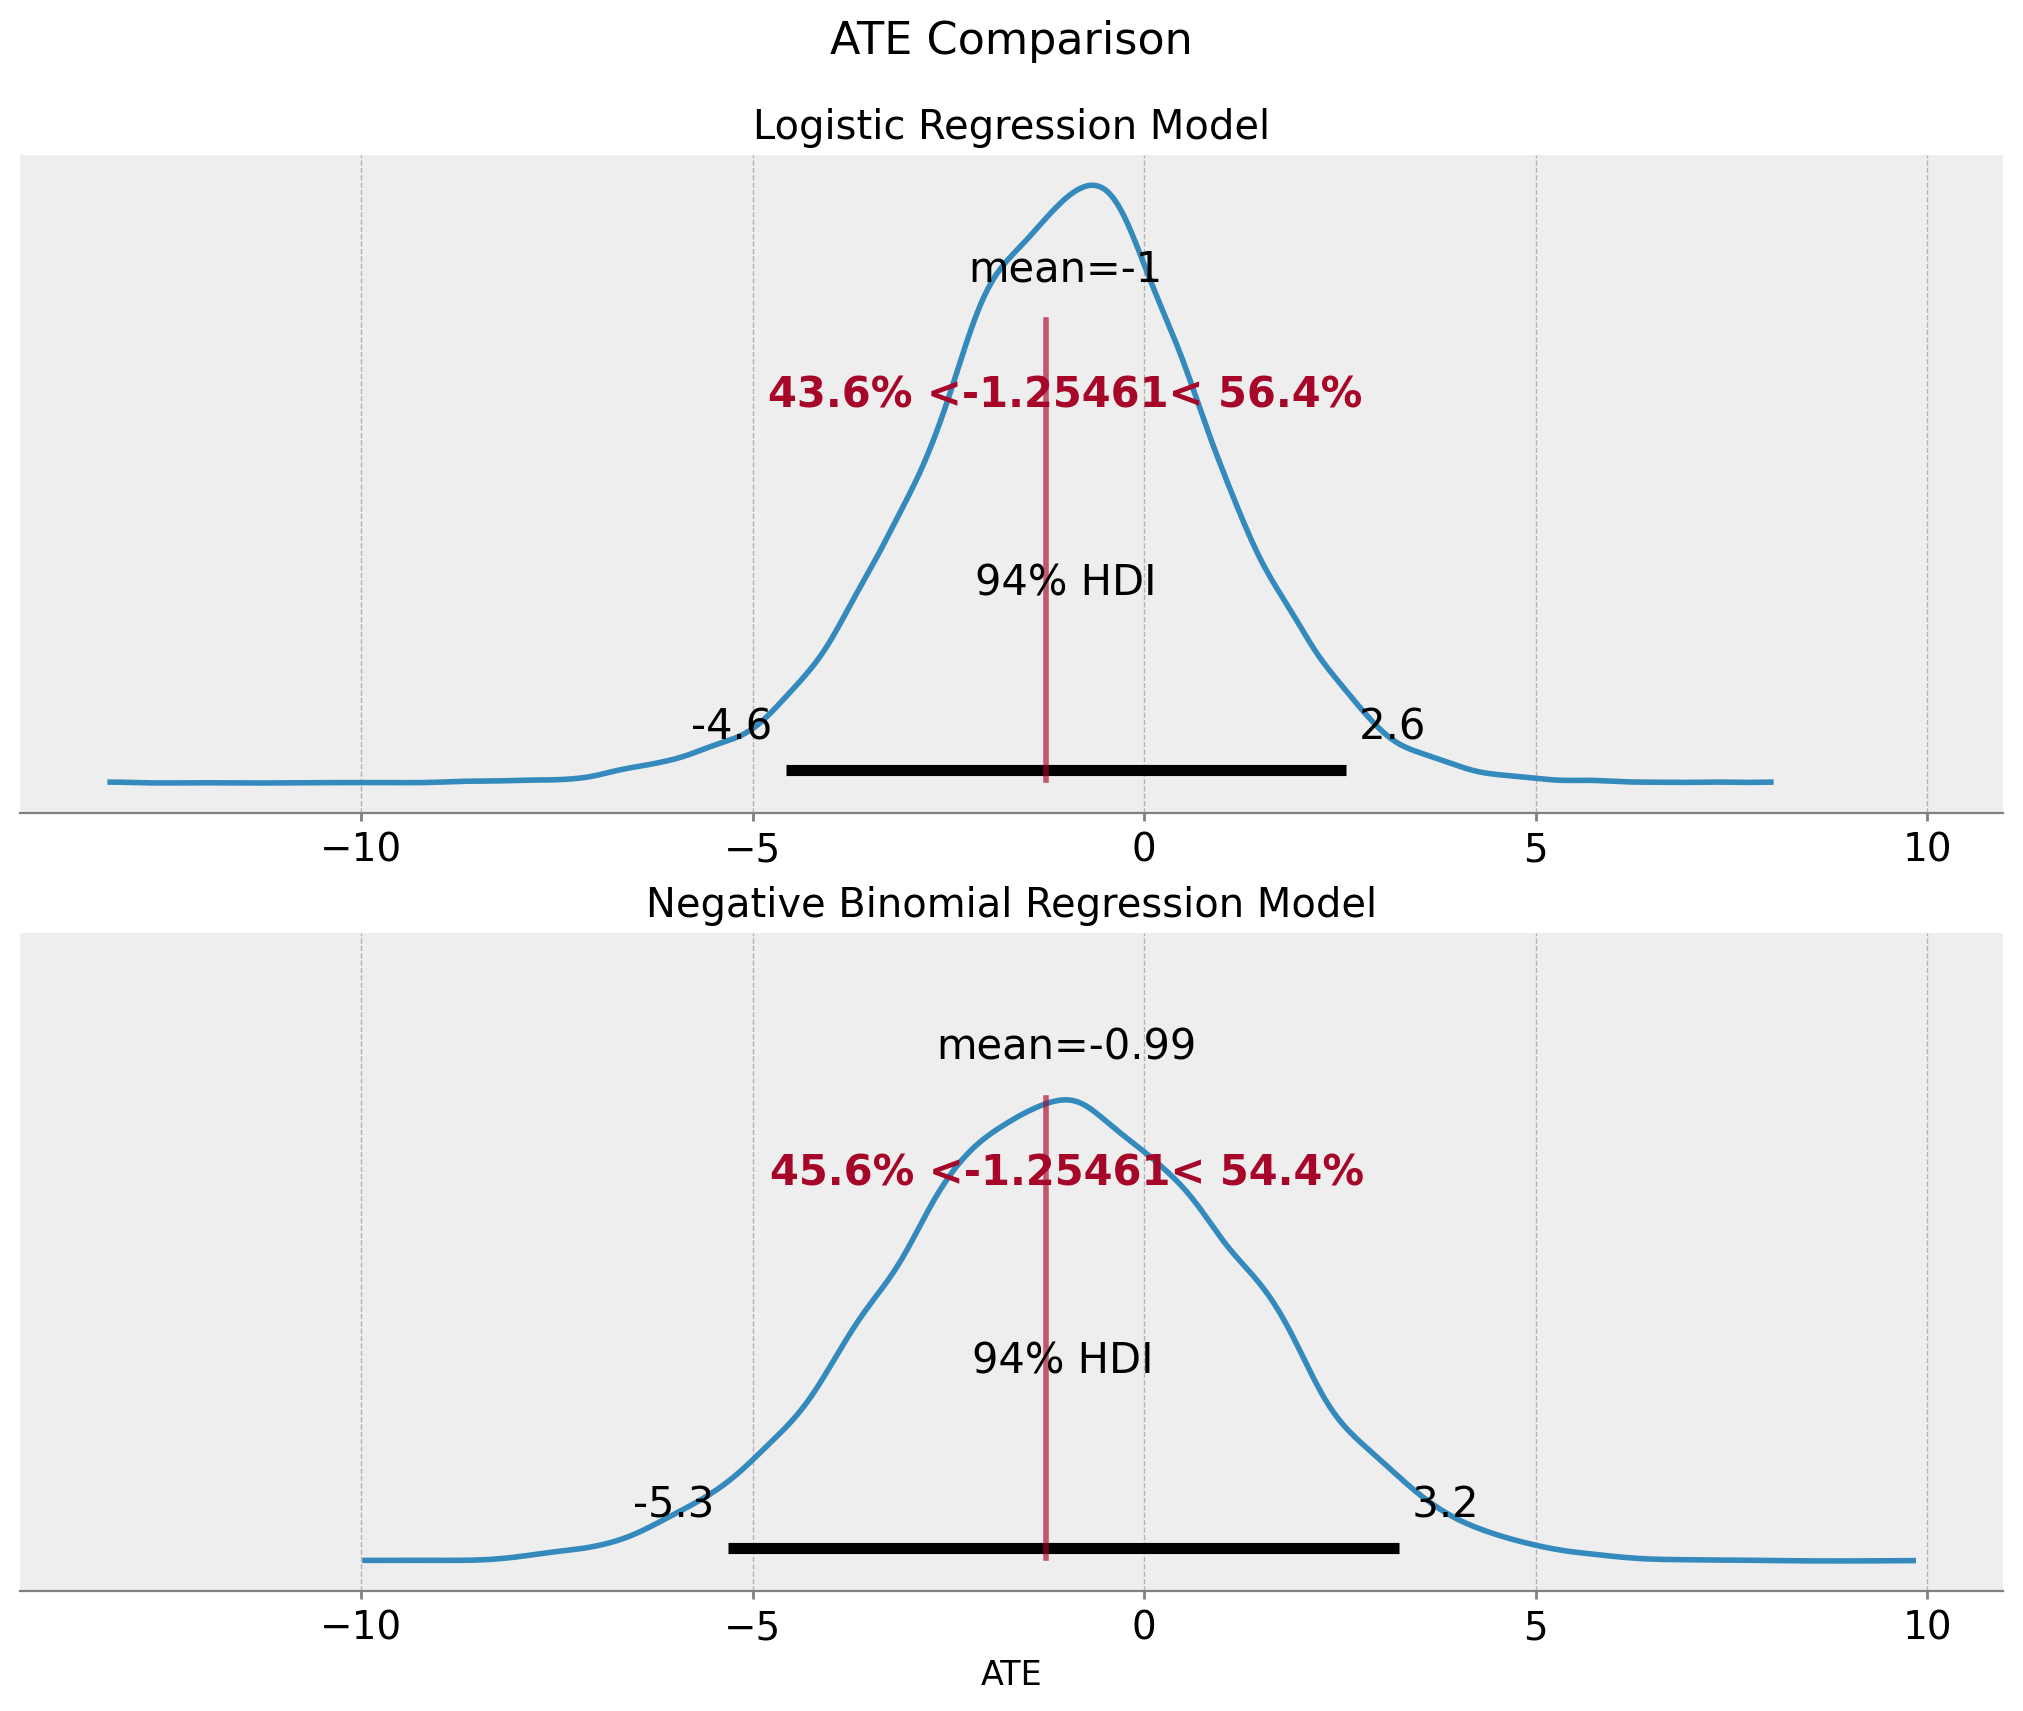

In [85]:
fig, ax = plt.subplots(
    nrows=2, ncols=1, sharex=True, sharey=True, figsize=(10, 8), layout="constrained"
)
az.plot_posterior(data=ate_samples, ref_val=diff_means, ax=ax[0])
ax[0].set(title="Logistic Regression Model")
az.plot_posterior(data=gaussian_idata, var_names=["trt"], ref_val=diff_means, ax=ax[1])
ax[1].set(title="Negative Binomial Regression Model", xlabel="ATE")
fig.suptitle("ATE Comparison", y=1.05, fontsize=16)